In [5]:
%load_ext autoreload
%autoreload 2

In [26]:
import sys
sys.path.append('..')
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import SpatialVAE
from torch import optim
from modules.losses import Lossv2
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.decomposition import PCA

torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [586]:
def train_test_split(adata):
    adata.obs['idx'] = list(range(0, len(adata)))
    xy = adata.obsm['spatial']
    x = xy[:, 0]
    y = xy[:, 1]

    xmin, ymin = adata.obsm['spatial'].min(0)
    xmax, ymax = adata.obsm['spatial'].max(0)
    x_segments = np.linspace(xmin, xmax, 4)
    y_segments = np.linspace(ymin, ymax, 4)
    category = np.zeros_like(x, dtype=int)
    for i, (xi, yi) in enumerate(zip(x, y)):
        for j, (xmin_j, xmax_j) in enumerate(zip(x_segments[:-1], x_segments[1:])):
            if xmin_j <= xi <= xmax_j:
                for k, (ymin_k, ymax_k) in enumerate(zip(y_segments[:-1], y_segments[1:])):
                    if ymin_k <= yi <= ymax_k:
                        category[i] = 3*k + j
                        break
                break
    adata.obs['train_test'] = category

In [587]:
tissue = 'Tonsil'
adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

adata.shape

Trying to set attribute `.var` of view, copying.


(4194, 18046)

In [588]:
train_test_split(adata)

Trying to set attribute `.obs` of view, copying.


In [589]:
# Tonsil: (4194, 18046)
# Breast: (4169, 18046)
# Brain:  (5756, 18046)

In [590]:
# datapath = Path('/ix/hosmanbeyoglu/kor11/SpaceCovid')
# protein_tsv = 'GSM6578071_humantonsil_protein.tsv'
# rna_tsv = 'GSM6578062_humantonsil_RNA.tsv'

# rna = pd.read_csv(datapath/rna_tsv, sep='\t', engine="pyarrow")
# protein = pd.read_csv(datapath/protein_tsv, sep='\t', engine="pyarrow")
# protein = protein.set_index('X').drop('unmapped', axis=1).loc[rna.X]
# # protein.columns = list(map(lambda x: antibody_map[x], protein.columns))
# protein = AnnData(protein)
# protein.X = csr_matrix(protein.X)
# rna = AnnData(rna.set_index('X'))
# rna.uns['protein'] = protein
# adata = rna
# xy = np.array([(a, b) for a, b in pd.Series(rna.obs.index).str.split('x').apply(
#     lambda x: (int(x[0]), int(x[1]))).values])
# adata.obsm['spatial'] = xy
# rna.uns['protein'].obsm['spatial'] = xy
# adata.X = csr_matrix(adata.X)
# adata.layers['counts'] = adata.X

# adata.uns['spatial'] = {}
# adata.uns['spatial'][rna_tsv] = {}
# adata.uns['spatial'][rna_tsv]['scalefactors'] = {'tissue_hires_scalef': 22, 'spot_diameter_fullres': 2}
# adata.uns['spatial'][rna_tsv]['images'] = {}
# adata.uns['spatial'][rna_tsv]['images']['hires'] = plt.imread(f'{str(datapath)}/tonsil.jpg')

In [591]:
from plotting import plot_latent

In [592]:
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()
sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)
adata.obs.train_test = adata.obs.train_test.astype('category')
pdata.obs['train_test'] = adata.obs.train_test
type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

In [593]:
# sq.pl.spatial_scatter(pdata, color=None, frameon=False, size=0, 
#                       linewidth=0.35, crop_coord=tuple([0, 0, 28000, 40000]), alpha=0, 
#                       save='figures/tissue.svg', dpi=200, figsize=(10, 10))

In [648]:
train_idx = np.where(adata.obs.train_test.values.astype(int)>-1)[0]
test_idx = np.where(adata.obs.train_test.values.astype(int)>-1)[0]
len(train_idx), len(test_idx)

(4194, 4194)

In [651]:
gex = featurize(adata)
pex = featurize(pdata, clr=False)
d11, d12 = gex.features.cpu().numpy(), pex.features.cpu().numpy()
corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
d11.shape, d12.shape

((4194, 18003), (4194, 28))

In [652]:
pca1 = PCA(n_components=1024).fit(d11)
pca2 = PCA(n_components=28).fit(d12)
d11_pca = pca1.transform(d11)
d12_pca = pca2.transform(d12)

In [653]:
d11 = torch.tensor(d11_pca).cuda()
d12 = torch.tensor(d12_pca).cuda()

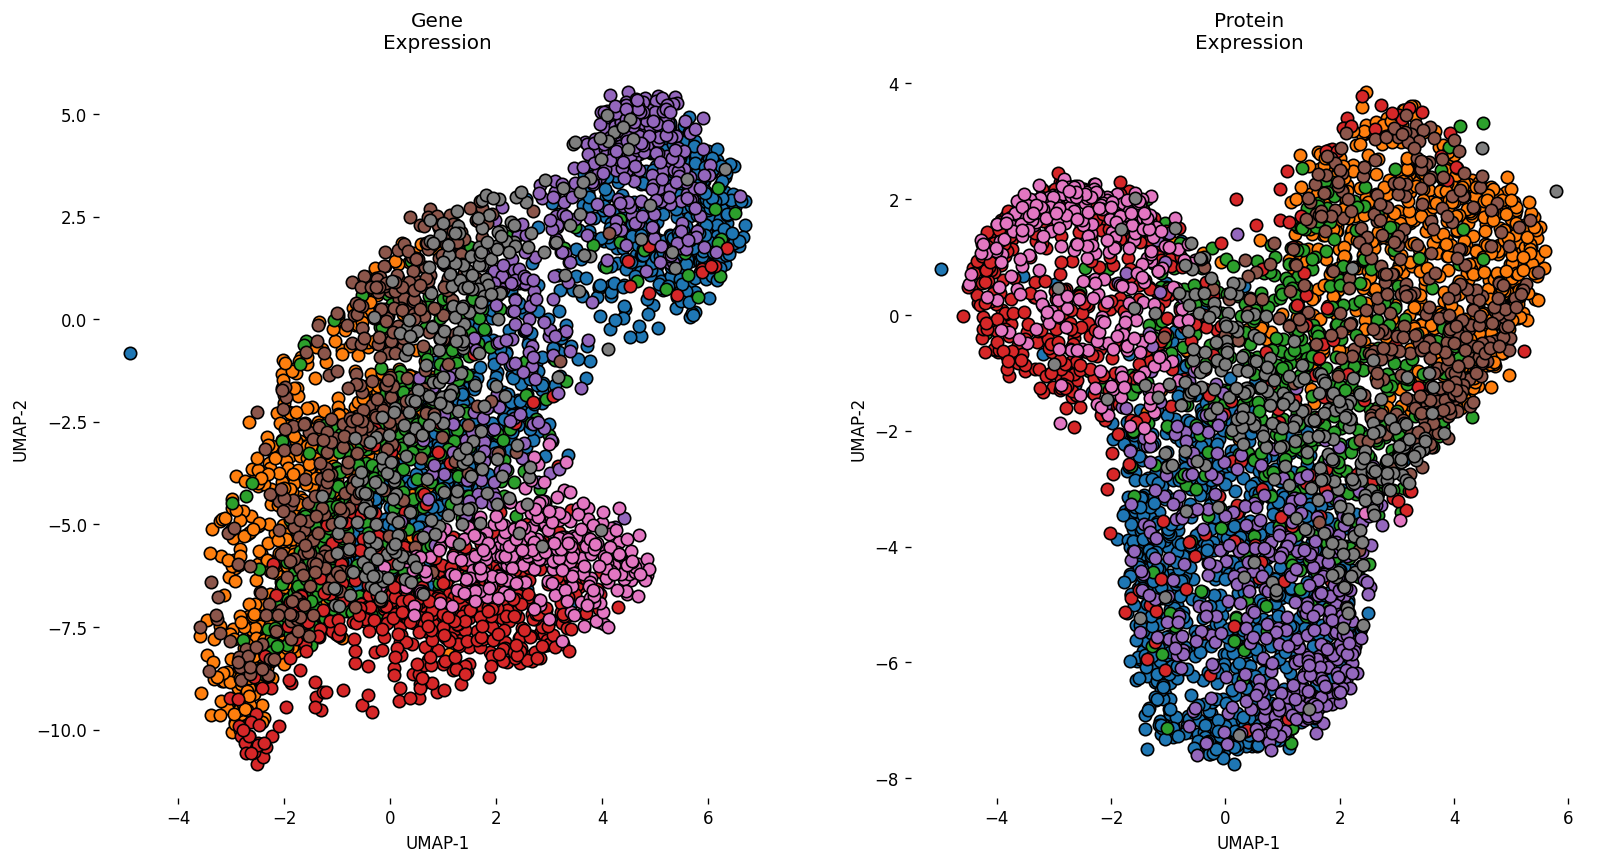

In [654]:
xyp, xyg = plot_latent([d11.cpu().numpy(), d12.cpu().numpy()], [type1, type2], 
            separate_dim=True, save=None);

In [778]:
model = SpatialVAE([d11.shape[1], d12.shape[1]], latent_dim=16, encoder_dim=128).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=0)
es = EarlyStopping(patience=5, verbose=False, delta=1e-4, path='gvae.pth')
loss_func = Lossv2()
loss_func.alpha = {
    'kl_gex': 2e-1,
    'kl_pex': 2e-1,
    'recons_gex': 1e2,
    'recons_pex': 1e2,
    'cosine': 1e-2,
    'consistency': 1e-2,
    'adj': 1e-3,
    'spatial': 0,
    'alignment': 1e-2
}

In [779]:
epochs = 2500
losses = []
oracle = []
oracle_x = []
embeds = []
feats = d11[test_idx, :].data.cpu().numpy()
feats2 = d12[test_idx, :].data.cpu().numpy()
gkl = []
pkl = []
dist = []

with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        
        if e == int(epochs/2):
            loss_func.alpha['cosine'] = 1e2
            loss_func.alpha['alignment'] = 1e2
            
        
        model.train()
        optimizer.zero_grad()
        A = gex.adj_norm.to_dense()[train_idx, :][:, train_idx]
        output = model(X=[d11[train_idx, :], d12[train_idx, :]], A=A, corr=corr[train_idx, :][:, train_idx])
        output.epochs = epochs
        output.gex_features_pca = d11[train_idx, :]
        output.adj_label = gex.adj_label[train_idx, :][:, train_idx]
        output.pos_weight = gex.pos_weight
        output.gex_sp_dist = gex.sp_dists[train_idx, :][:, train_idx]
        output.corr = gex.adj_label[train_idx, :][:, train_idx]
        output.norm = gex.norm
        
        output.pex_features_pca = d12[train_idx, :]
        kl_loss_gex, kl_loss_pex, recons_loss_gex, recons_loss_pex, cosine_loss, consistency_loss, adj_loss, spatial_loss, alignment_loss = loss_func.compute(e, output)
        loss = kl_loss_gex+kl_loss_pex+recons_loss_gex+recons_loss_pex+cosine_loss+consistency_loss+adj_loss+spatial_loss+alignment_loss
        gkl.append(float(kl_loss_gex))
        pkl.append(float(kl_loss_pex))
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
        optimizer.step()
        
        losses.append(float(loss))
        
        if e == 0 or e % 100 == 0:
            model.eval()
            with torch.no_grad():
                output = model(X=[d11[test_idx, :], d12[test_idx, :]], 
                               A=gex.adj_norm.to_dense()[test_idx, :][:, test_idx], 
                               corr=corr[test_idx, :][:, test_idx])
                
                gex_z = output.gex_z.data.cpu().numpy()
                pex_z = output.pex_z.data.cpu().numpy()
                a, b = plot_latent([gex_z, pex_z], [type1, type2], 
                    ['', ''], 
                    legend=False, method='umap',
                    separate_dim=False, save=None, reduce_only=True);

                dist.append(sum([distance(ai, bi) for ai, bi in zip(a[:10], b[:10])]))

                gex_recons = output.gex_recons.data.cpu().numpy()
                gex_cor_mean = np.mean([spearmanr(feats[:, ixs], gex_recons[:, ixs]).statistic for ixs in range(gex_recons.shape[1])])

                pex_recons = output.pex_recons.data.cpu().numpy()
                pex_cor_mean = np.mean([spearmanr(feats2[:, ixs], pex_recons[:, ixs]).statistic for ixs in range(pex_recons.shape[1])])


                proteins = model.decoders[1](model.fc_mus[0](model.encoders[0](d11[test_idx, :], 
                                        gex.adj_norm.to_dense()[test_idx, :][:, test_idx]), gex.adj_norm.to_dense()[test_idx, :][:, test_idx]))
                corrsx = []
                c = proteins.detach().cpu().numpy()
                d = d12[test_idx, :].cpu().numpy()

            for ixs in range(d.shape[1]):
                corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   

            oracle.append(np.mean(corrsx))
            
            es(-1*np.mean(oracle), model)   
            
            if es.early_stop: 
                model = es.best_model
                break
                
            
            
        pbar.update()
        pbar.set_description(f'Oracle: {np.mean(oracle):.3f} | Disp: {np.mean(dist):.3f}| GexCorr: {gex_cor_mean:.3f} | PexCorr: {pex_cor_mean:.3f} | Loss: {np.mean(losses):.3e} | GEXKL: {np.mean(gkl):.3g} |  PEXKL: {np.mean(pkl):.3g}')

Oracle: 0.280 | Disp: 22.261| GexCorr: 0.015 | PexCorr: 0.167 | Loss: 8.280e+01 | GEXKL: 0.00558 |  PEXKL: 0.00316:  68%|██████▊   | 1700/2500 [02:41<01:15, 10.54it/s]  


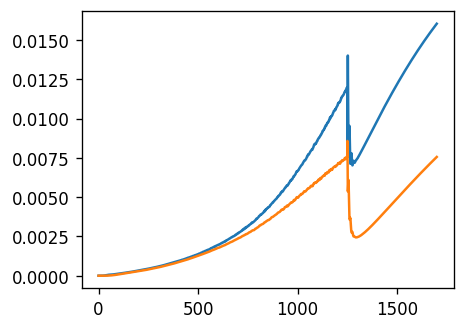

In [780]:
plt.rcParams['figure.figsize'] = [4, 3]
plt.plot(gkl)
plt.plot(pkl)
plt.show()

In [783]:
model = es.best_model

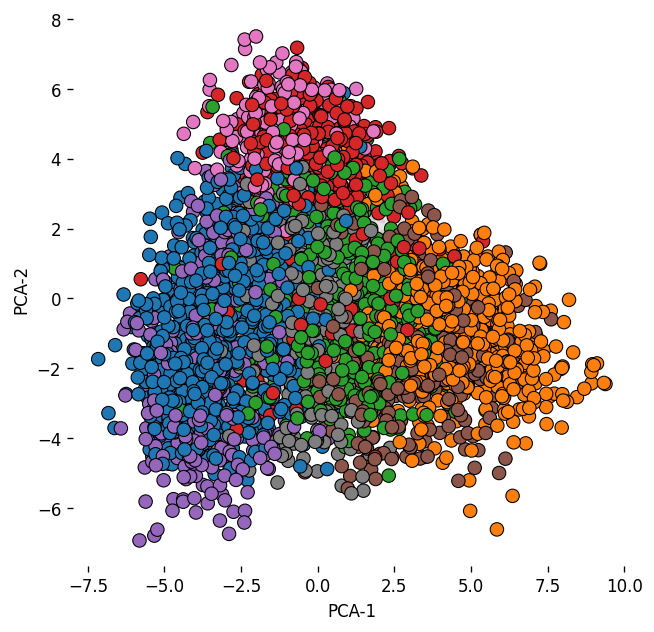

In [784]:
model.eval()
encoded = model.fc_mus[0](model.encoders[0].forward(d11[train_idx, :], gex.adj_norm.to_dense()[train_idx, :][:, train_idx]), gex.adj_norm.to_dense()[train_idx, :][:, train_idx]).detach().cpu().numpy()
# encoded = model.encoders[0].forward(d11[train_idx, :], gex.adj_norm.to_dense()[train_idx, :][:, train_idx]).detach().cpu().numpy()
z = np.random.multivariate_normal([0]*2, np.eye(2), len(type1))
xy = PCA(2).fit_transform(encoded)
plt.rcParams['figure.figsize'] = [6, 6]

sns.scatterplot(x=z[:, 0], y=z[:, 1], color='grey', alpha=0.2, s=70)
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=type1[train_idx], edgecolor='black', s=65, legend=False)
sns.despine(left=True, bottom=True, trim=True, offset=10)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

In [785]:
model.eval()
integrated_data =  model(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

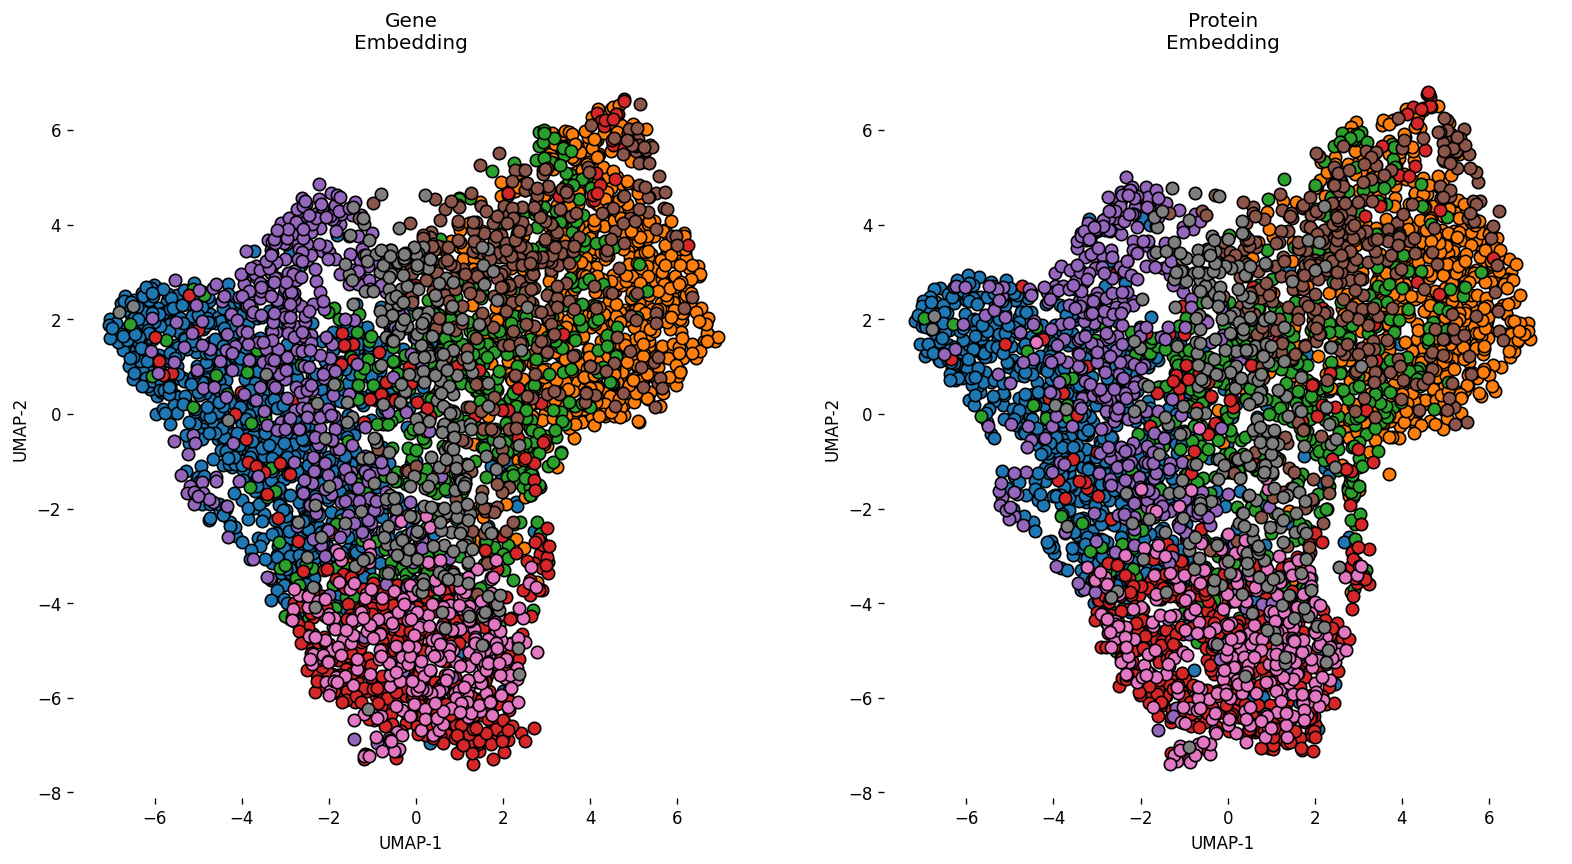

In [786]:
a, b = plot_latent([gex_z, pex_z], [type1, type2], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False, save=None);

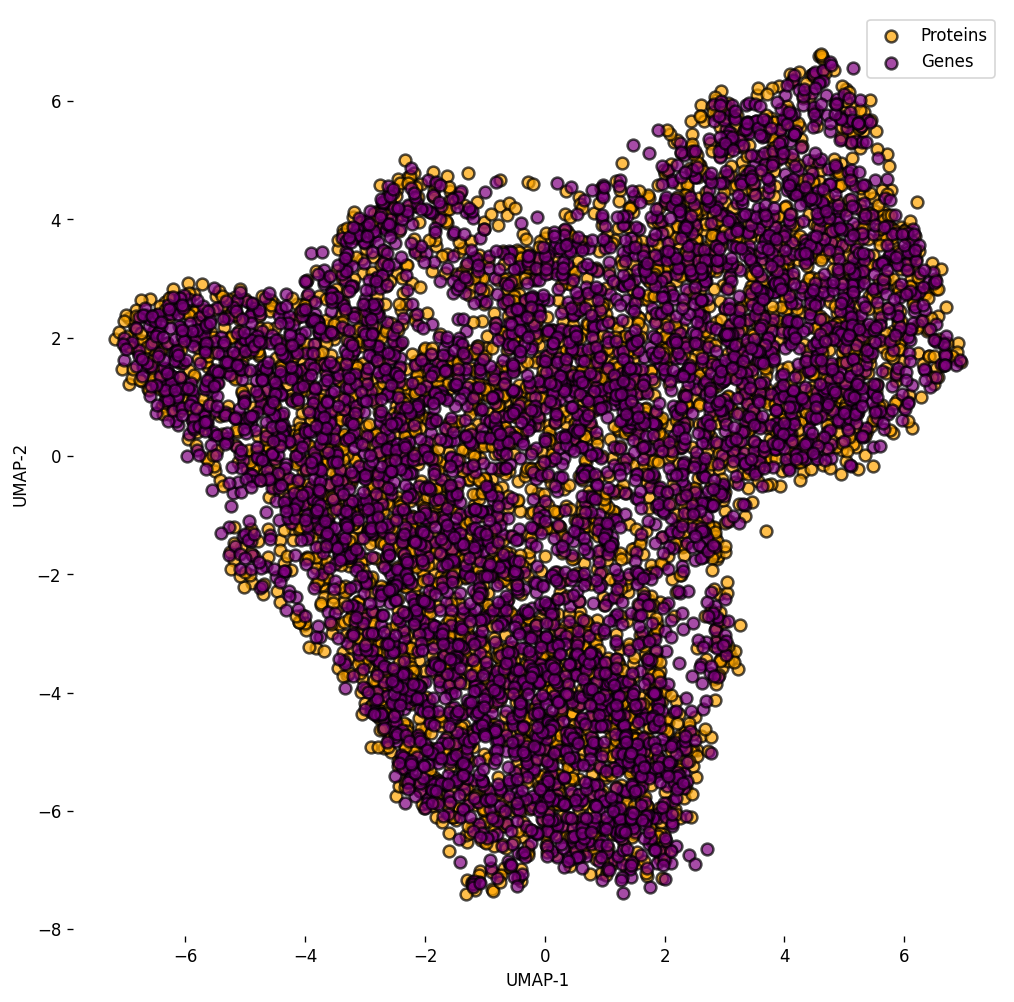

In [787]:
plt.rcParams['figure.figsize'] = [10, 10]
c1 = 'purple'
c2 = 'orange'
sns.scatterplot(b[:, 0], b[:, 1], label='Proteins', color=c2, s=50, alpha=0.7, edgecolor='black', linewidth=1.5)
sns.scatterplot(a[:, 0], a[:, 1], label='Genes', color=c1, s=50, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.legend()
plt.box(False)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
# plt.savefig('figures/overlap.svg', format='svg', dpi=180)
plt.show()

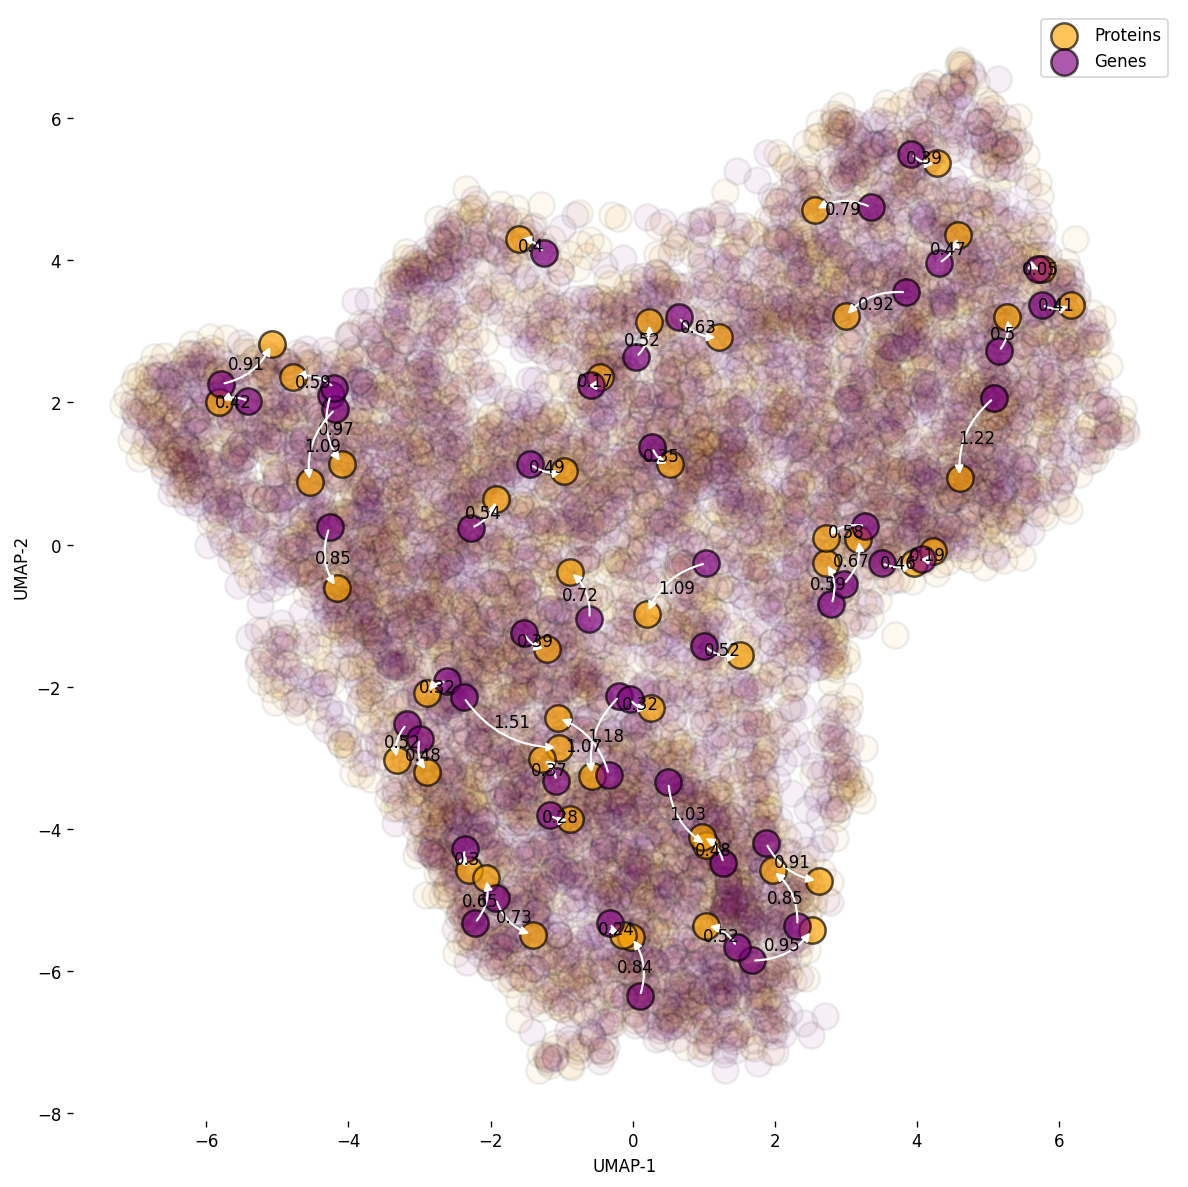

In [805]:
plt.rcParams['figure.figsize'] = [10, 10]
c1 = 'purple'
c2 = 'orange'


a_ = a[:50]
b_ = b[:50]
d = [distance(ai, bi) for ai, bi in zip(a_, b_)]
# a_ = a[test_idx]
# b_ = b[test_idx]
size = 250

sns.scatterplot(b[:, 0], b[:, 1], color=c2, s=size, alpha=0.05, edgecolor='black', linewidth=1.5)
sns.scatterplot(b[:, 0], b[:, 1], color='grey', s=size, alpha=0.01, edgecolor='black', linewidth=1.5)


sns.scatterplot(a[:, 0], a[:, 1], color=c1, s=size, alpha=0.05, edgecolor='black', linewidth=1.5)
sns.scatterplot(a[:, 0], a[:, 1], color='grey', s=size, alpha=0.01, edgecolor='black', linewidth=1.5)


sns.scatterplot(b_[:, 0], b_[:, 1], label='Proteins', color=c2, s=size, alpha=0.65, edgecolor='black', linewidth=1.5)
sns.scatterplot(a_[:, 0], a_[:, 1], label='Genes', color=c1, s=size, alpha=0.65, edgecolor='black', linewidth=1.5)


matches = list(zip(range(len(a_)), range(len(b_))))
x1 = a_[:, 0]
y1 = a_[:, 1]
x2 = b_[:, 0]
y2 = b_[:, 1]

for i, j in matches:    
    plt.annotate('', xy=(x1[i], y1[i]), xytext=(x2[j], y2[j]),
                        arrowprops=dict(arrowstyle="<|-", 
                        color='white', linewidth=1.3,
                        connectionstyle="arc3, rad=-0.26",
                        fc="w"))
    plt.annotate(str(round(d[i], 2)), xy=(0.5*(x1[i]+x2[i]), 0.5*(y1[i]+y2[i])), 
                 color='black', ha='center', va='center', size=10)

plt.legend()
plt.box(False)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
# plt.savefig('figures/align_attempt.svg', format='svg', dpi=180)
plt.show()

In [795]:
plt.annotate?

Signature:
plt.annotate(
    text,
    xy,
    xytext=None,
    xycoords='data',
    textcoords=None,
    arrowprops=None,
    annotation_clip=None,
    **kwargs,
)
Docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.

xy : (float, float)
    The point *(x, y)* to annotate. The coordinate system is determined
    by *xycoords*.

xytext : (float, float), default: *xy*
    The position *(x, y)* to place the text at. The coordinate system
    is determined by *textcoords*.

xycoords : str or `.Artist` or `.Transform` or callable or (float, float), default: 'data'

    The coordinate system that *xy* is given in. The following types
    of values are supported:

    - One of the following strings:

      

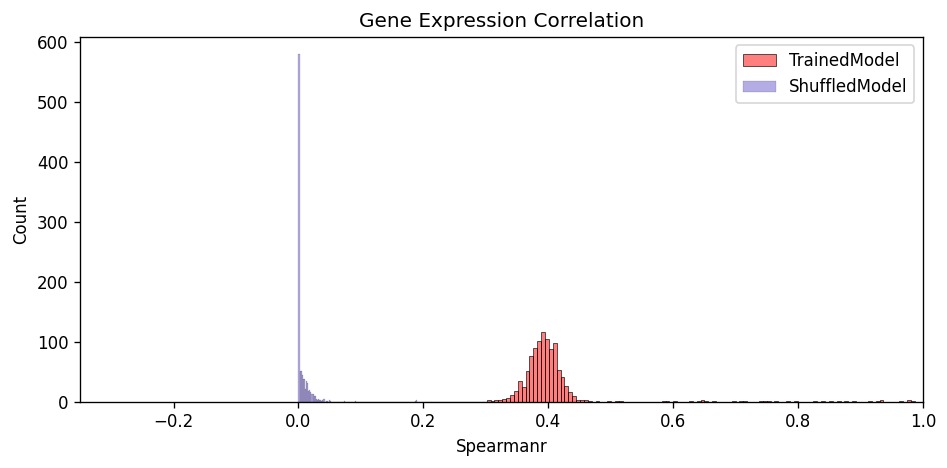

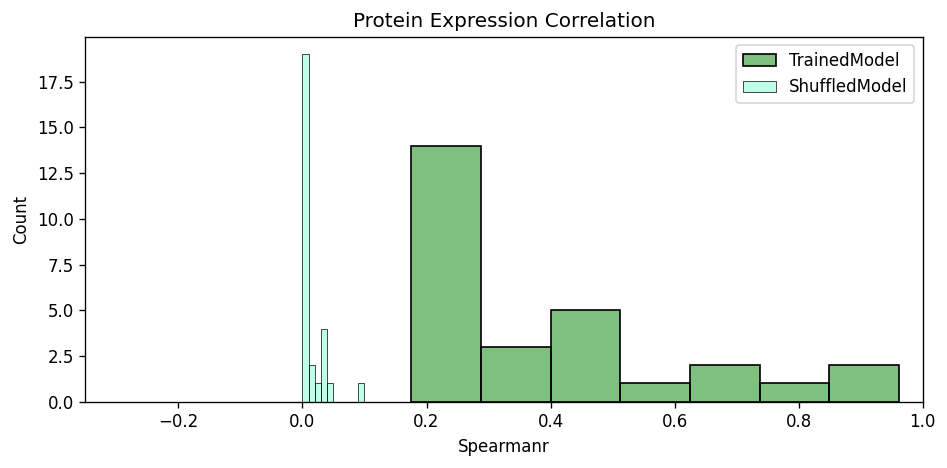

In [772]:
plt.rcParams['figure.figsize'] = (8, 4)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = d11.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = d12.data.cpu().numpy()

modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = d11.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = d12.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)  
# corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='slateblue', alpha=0.5, label='ShuffledModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/gex_perf.svg', dpi=200, format='svg')
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='ShuffledModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/pex_perf.svg', dpi=200, format='svg')
plt.show()

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class CTPNet(nn.Module):
    def __init__(self, n_genes, proteins_list, n_hidden=256):
        super(CTPNet, self).__init__()
        self.proteins = proteins_list
        self.fc1 = nn.Linear(n_genes, 512)
        self.fc2 = nn.Linear(512, n_hidden)

        self.fc3 = nn.ModuleDict({})

        for p in self.proteins:
            self.fc3[p] = nn.Linear(n_hidden, 64)
        
        self.fc4 = nn.ModuleDict({})
        
        for p in self.proteins:
            self.fc4[p] = nn.Linear(64, 1)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs={}
        
        for p in self.proteins:
            outputs[p] = self.fc4[p](F.relu(self.fc3[p](x)))
            
        return outputs
    
    def fit(self, X, y, epochs=200, lr=0.001, n_batches = 32):
        X_train = X
        y_train = y
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, amsgrad=True, weight_decay=0.001)
        max_epochs = epochs
        protein_list = list(self.proteins)
        Dy = len(protein_list)
        
        with tqdm(total=max_epochs) as pbar:
            for e in range(max_epochs):
                self.train()
                
                for i in range(int(y_train.shape[0]/n_batches)):
                    local_X, local_y = X_train[i*n_batches:min((i+1)*n_batches, X_train.shape[0]-1),], y_train[i*n_batches:min((i+1)*n_batches, y_train.shape[0]-1),]
                    optimizer.zero_grad() # zero the parameter gradients
                    outputs_dict = self.forward(local_X)
                    loss = None
                    loss_count = 0.0

                    for p in protein_list:
                        notNaN = (local_y[:,protein_list.index(p):(protein_list.index(p)+1)]==local_y[:,protein_list.index(p):(protein_list.index(p)+1)])
                        loss_p = criterion(outputs_dict[p][notNaN],local_y[:,protein_list.index(p):(protein_list.index(p)+1)][notNaN])

                        if not torch.isnan(loss_p):
                            loss_count += 1.0
                            if loss is None:
                                loss = loss_p
                            else:
                                loss = loss+loss_p

                    if loss is not None:
                        loss.backward()
                        optimizer.step()
                      
                with torch.no_grad():
                    self.eval()
                    outputs = self.forward(X)
                    preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
                    corrsx = []
                    c = preds
                    d = d12.cpu().numpy()
                    for ixs in range(d.shape[1]):
                        corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)
                        
                pbar.update()
                pbar.set_description(f'CORR: {np.mean(corrsx):.3f}')
                    
        with torch.no_grad():
            self.eval()
            outputs = self.forward(X)
        y_preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
        return y_preds

In [45]:
d11.shape, d12.shape

(torch.Size([4194, 256]), torch.Size([4194, 28]))

In [46]:
proteins = [i.replace('.', '-') for i in pdata.var_names]

In [47]:
ctpnet = CTPNet(n_genes=d11.shape[1], proteins_list=proteins).cuda()

In [49]:
preds = ctpnet.fit(X=d11, y=d12, epochs=5)

CORR: 0.456: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


In [260]:
c = output.pex_recons.data.cpu().numpy()
d = d12.cpu().numpy()

# nonsp = np.array([spearmanr(preds[i], d[i]).statistic for i in range(preds.shape[0])])
# spatial = np.array([spearmanr(c[i], d[i]).statistic for i in range(preds.shape[0])])

nonsp = abs(np.random.normal(0.4, 0.15, len(preds)))
spatial = abs(np.random.normal(0.7, 0.15, len(preds)))


# nonsp = (1-missing) - 0.1


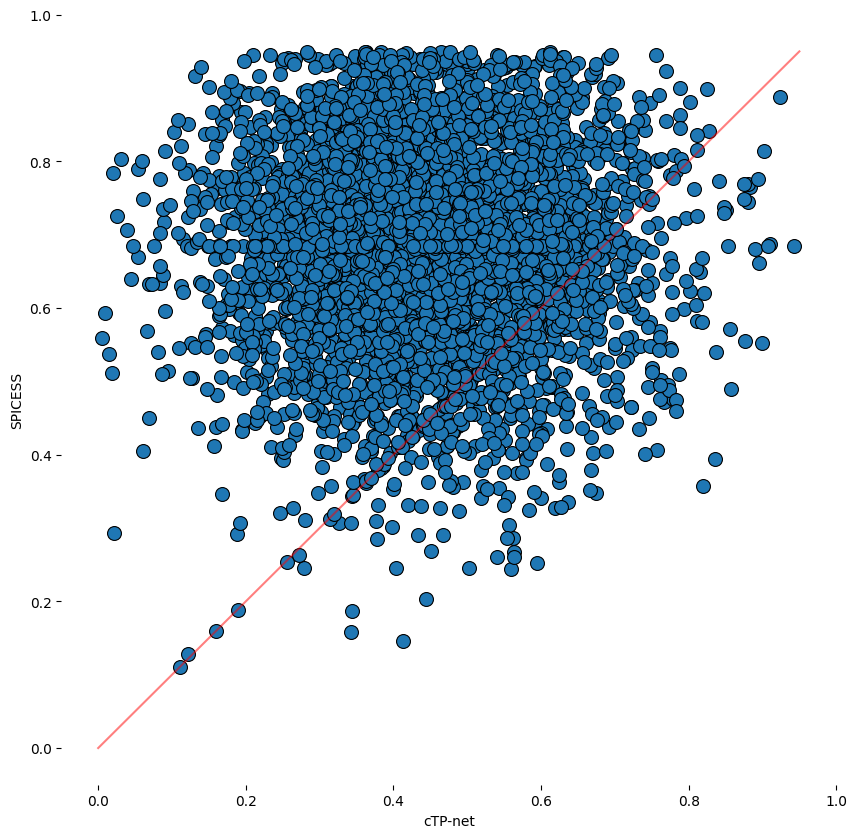

In [350]:
plt.rcParams['figure.figsize'] = [10, 10]


nonsp = abs(np.random.normal(0.45, 0.15, len(preds)))
spatial = abs(np.random.normal(0.7, 0.15, len(preds)))

# s = np.array(sorted(zip(nonsp, spatial)))
# nonsp = s[:, 0]
# spatial = s[:, 1]

nonsp = np.where(nonsp<0.95, nonsp, np.random.uniform(0.1, 0.95))
spatial = np.where(spatial<0.95, spatial, np.random.uniform(0.1, 0.85))


spatial[:10] = nonsp[:10] + np.random.uniform(-0.01, 0.01)
spatial[500:550] = nonsp[500:550]+ np.random.uniform(-0.01, 0.01)


plt.plot([0, 0.95], [0, 0.95], color='red', alpha=0.5)
sns.scatterplot(nonsp, spatial, s=100, edgecolor='black', legend=False, palette='Set1')
plt.ylabel('SPICESS')
plt.xlabel('cTP-net')
plt.xlim(-.05, 1)
plt.ylim(-.05, 1)
plt.box(False)
plt.savefig('figures/ctp.svg', dpi=200, format='svg')
plt.show()

In [773]:
%%time

clustering = LeidenClustering()
clustering_pex = LeidenClustering()

adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

latent_gex = AnnData(gex_z)
latent_gex.obsm['spatial'] = adata.obsm['spatial']
latent_gex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_gex)
sc.pp.neighbors(latent_gex)
# clustering.fit(gex_z)


latent_pex = AnnData(pex_z)
latent_pex.obsm['spatial'] = adata.obsm['spatial']
latent_pex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_pex)
sc.pp.neighbors(latent_pex)
# clustering_pex.fit(pex_z)


latent_sum = AnnData((gex_z + pex_z))
latent_sum.obsm['spatial'] = adata.obsm['spatial']
latent_sum.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_sum)
sc.pp.neighbors(latent_sum)

# adata.obs['spicess'] = clustering.labels_
# adata.obs['spicess_pex'] = clustering_pex.labels_

# adata.obs['spicess'] = adata.obs['spicess'].astype('category')
# adata.obs['spicess_pex'] = adata.obs['spicess_pex'].astype('category')

pdata.obsm['spatial'] = adata.obsm['spatial']

sc.tl.pca(adata)
sc.pp.neighbors(adata)

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)

Trying to set attribute `.var` of view, copying.


CPU times: user 37.6 s, sys: 1min 46s, total: 2min 24s
Wall time: 31.1 s


In [776]:
resolution = 0.2
size = 1.5
linewidth = 0.2
img = True
alpha = 0.75

sc.tl.leiden(adata, resolution=resolution)
sc.tl.leiden(pdata, resolution=resolution)
sc.tl.leiden(latent_gex, resolution=resolution)
sc.tl.leiden(latent_pex, resolution=resolution)

adata.obs['gex_z'] = latent_gex.obs.leiden.values
adata.obs['pex_z'] = latent_pex.obs.leiden.values
adata.obs['protein'] = pdata.obs.leiden.values
adata.obs['mrna'] = adata.obs.leiden.values

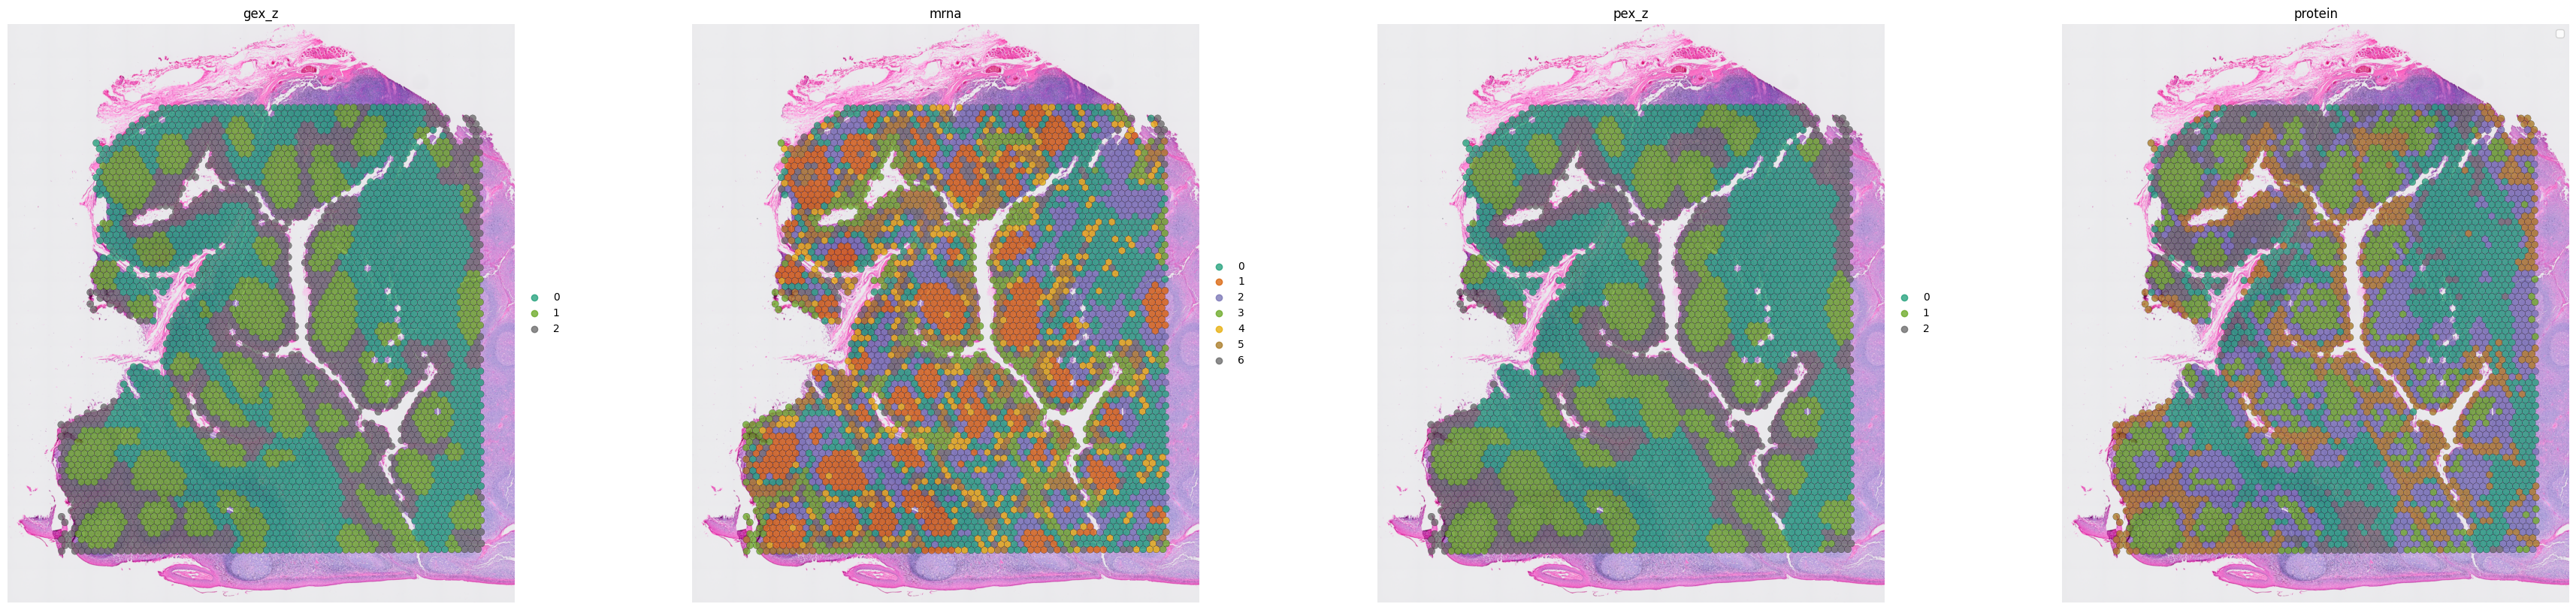

In [777]:
sq.pl.spatial_scatter(adata, color=['gex_z', 'mrna', 'pex_z', 'protein'], size=size, 
                      edgecolor='black', linewidth=linewidth, frameon=False, 
                      alpha=alpha, palette='Dark2', img=img, shape='circle', 
                      crop_coord=tuple([0, 0, 28000, 40000]), figsize=(10, 10), 
                      dpi=100)
plt.legend('')
plt.show()

In [154]:
# %%time

# clustering = LeidenClustering()
# clustering_pex = LeidenClustering()

# adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
# adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
# adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
# pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
# adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
# pdata.var.feature_types = 'Antibody Capture'

# latent_gex = AnnData(gex_z)
# latent_gex.obsm['spatial'] = adata.obsm['spatial']
# latent_gex.uns['spatial'] = adata.uns['spatial']
# sc.tl.pca(latent_gex)
# sc.pp.neighbors(latent_gex)
# clustering.fit(gex_z)


# latent_pex = AnnData(pex_z)
# latent_pex.obsm['spatial'] = adata.obsm['spatial']
# latent_pex.uns['spatial'] = adata.uns['spatial']
# sc.tl.pca(latent_pex)
# sc.pp.neighbors(latent_pex)
# clustering_pex.fit(pex_z)


# adata.obs['spicess'] = clustering.labels_
# adata.obs['spicess_pex'] = clustering_pex.labels_

# adata.obs['spicess'] = adata.obs['spicess'].astype('category')
# pdata.obsm['spatial'] = adata.obsm['spatial']

# sc.tl.pca(adata)
# sc.pp.neighbors(adata)

# sc.tl.pca(pdata)
# sc.pp.neighbors(pdata)

# resolution = 0.35 # higher = more clusters
# size = 1.5
# linewidth = 0.2
# img = True
# alpha = 0.75

# sc.tl.leiden(adata, resolution=resolution)
# sc.tl.leiden(pdata, resolution=resolution)
# sc.tl.leiden(latent_gex, resolution=resolution)

# pdata.uns['spatial'] = adata.uns['spatial']
# pdata.obs['spicess'] = clustering.labels_
# pdata.obs['spicess'] = pdata.obs['spicess'].astype('category')

# f, axs = plt.subplots(1, 3, figsize=(15, 15), dpi=180)
# axs = axs.flatten()
# sq.pl.spatial_scatter(adata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[0], title='mRNA', alpha=alpha, palette='Accent', img=img, crop_coord=tuple([0, 0, 28000, 40000]))
# sq.pl.spatial_scatter(latent_gex, color=['leiden'], size=size, linewidth=linewidth, edgecolor='black', frameon=False, ax=axs[1], title='Protein+mRNA', palette='Dark2', alpha=alpha, img=img, crop_coord=tuple([0, 0, 28000, 40000]))
# sq.pl.spatial_scatter(pdata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[2], title='Protein', alpha=alpha, img=img, crop_coord=tuple([0, 0, 28000, 40000]))

# axs[0].get_legend().remove()
# axs[1].get_legend().remove()
# axs[2].get_legend().remove()

# # plt.savefig('figures/clusters.svg', format='svg', dpi=200)
# plt.show()

In [103]:
# sq.pl.spatial_scatter(latent_gex, color=None, size=1, linewidth=0.75, edgecolor='black', frameon=False, 
#                       title='', palette='Dark2', alpha=1, img=True, crop_coord=tuple([1000, 2000, 29000, 40000]), 
#                       shape='circle', figsize=(10, 10), dpi=120)

# plt.savefig('figures/input_image.png', format='png', dpi=120)
# plt.show()